In [ ]:
import tarfile
import os
import csv
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import PIL
from tqdm import tqdm
%matplotlib inline

## Preprocessing and Augmenting Stanford Cars

Bounding boxes are provided by Stanford, we use them to crop and augment images before saving them in folders, that can be loaded in by Keras ImageDataGenerator.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate http://ai.stanford.edu/~jkrause/car196/cars_train.tgz 

train_tar = tarfile.open('cars_train.tgz')
train_tar.extractall('./train') # specify which folder to extract to
train_tar.close()

--2022-05-02 01:34:52--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  94.3MB/s    in 10s     

2022-05-02 01:35:02 (90.3 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [ ]:
#Download full testing data (~933MB)
!wget --no-check-certificate http://ai.stanford.edu/~jkrause/car196/cars_test.tgz #downloaded directory
#extract testing data to tmp/test/
test_tar = tarfile.open('cars_test.tgz')
test_tar.extractall('./test') # specify which folder to extract to
test_tar.close()

--2022-05-02 01:35:11--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  87.3MB/s    in 12s     

2022-05-02 01:35:23 (79.4 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [ ]:
#Download labels (~0.3MB)
!wget --no-check-certificate https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz -O car_devkit.tgz
Path("/tmp/annos").mkdir(parents=True, exist_ok=True)
!wget --no-check-certificate \
    https://people.ucsc.edu/~jwang402/carslabel/anno_test.csv \
    -O anno_test.csv
#extract labels to /tmp/labels/
label_tar = tarfile.open('car_devkit.tgz')
label_tar.extractall('labels') # specify which folder to extract to
label_tar.close()

--2022-05-02 01:35:33--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  --.-KB/s    in 0.1s    

2022-05-02 01:35:33 (2.72 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]

--2022-05-02 01:35:33--  https://people.ucsc.edu/~jwang402/carslabel/anno_test.csv
Resolving people.ucsc.edu (people.ucsc.edu)... 128.114.119.88
Connecting to people.ucsc.edu (people.ucsc.edu)|128.114.119.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225299 (220K) [text/csv]
Saving to: ‘anno_test.csv’

anno_test.csv       100%[===================>] 220.02K  --.-KB/s    in 0.1s    

2022-05-02 01:35:33 (2.14 MB/s) - ‘anno_test.csv’ saved [225299/225299]



In [ ]:
meta = loadmat('/content/labels/devkit/cars_meta.mat')
meta.keys()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])

In [ ]:
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classDict = {}
classCount = 1
for c in classes:
  classDict.update({classCount:c[0]})
  classCount += 1
counter = 0
for num, model in classDict.items():
  print(f'Car Model {num}: {model}')
  counter += 1
print('...')
print(f'There are a total of {len(classDict.items())} cars')

Car Model 1: AM General Hummer SUV 2000
Car Model 2: Acura RL Sedan 2012
Car Model 3: Acura TL Sedan 2012
Car Model 4: Acura TL Type-S 2008
Car Model 5: Acura TSX Sedan 2012
Car Model 6: Acura Integra Type R 2001
Car Model 7: Acura ZDX Hatchback 2012
Car Model 8: Aston Martin V8 Vantage Convertible 2012
Car Model 9: Aston Martin V8 Vantage Coupe 2012
Car Model 10: Aston Martin Virage Convertible 2012
Car Model 11: Aston Martin Virage Coupe 2012
Car Model 12: Audi RS 4 Convertible 2008
Car Model 13: Audi A5 Coupe 2012
Car Model 14: Audi TTS Coupe 2012
Car Model 15: Audi R8 Coupe 2012
Car Model 16: Audi V8 Sedan 1994
Car Model 17: Audi 100 Sedan 1994
Car Model 18: Audi 100 Wagon 1994
Car Model 19: Audi TT Hatchback 2011
Car Model 20: Audi S6 Sedan 2011
Car Model 21: Audi S5 Convertible 2012
Car Model 22: Audi S5 Coupe 2012
Car Model 23: Audi S4 Sedan 2012
Car Model 24: Audi S4 Sedan 2007
Car Model 25: Audi TT RS Coupe 2012
Car Model 26: BMW ActiveHybrid 5 Sedan 2012
Car Model 27: BMW 1 S

In [ ]:
labels = loadmat('./labels/devkit/cars_train_annos.mat')

trainLabels = [[row.flat[0] for row in line] for line in labels['annotations'][0]]
columns = ['x1', 'y1', 'x2', 'y2', 'class', 'file_name']
bounding_labels = pd.DataFrame(trainLabels, columns=columns)
bounding_labels.head(10)

,x1,y1,x2,y2,class,file_name
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,-122,00004.jpg
4,14,36,133,99,106,00005.jpg
5,259,289,515,416,123,00006.jpg
6,88,80,541,397,89,00007.jpg
7,73,79,591,410,96,00008.jpg
8,20,126,1269,771,-89,00009.jpg
9,21,110,623,367,58,00010.jpg


In [ ]:
lf = loadmat('/content/labels/devkit/cars_test_annos.mat')
testLabels = [[row.flat[0] for row in line] for line in lf['annotations'][0]]

#Test labels class and fname
with open('anno_test.csv') as csv_file:
    read = csv.reader(csv_file, delimiter=',')
    testDict = {}
    classCount = 1
    for row in read:
        testDict.update({row[0]:row[5]})
        classCount = classCount + 1
    print(len(testDict), 'processed')

columns = ['x1', 'y1', 'x2', 'y2', 'file_name']
testing = pd.DataFrame(testLabels, columns=columns)
testing.head(10)

8041 processed


,x1,y1,x2,y2,file_name
0,30,52,246,147,00001.jpg
1,100,19,576,203,00002.jpg
2,51,105,968,659,00003.jpg
3,67,84,581,407,00004.jpg
4,140,151,593,339,00005.jpg
5,20,77,420,301,00006.jpg
6,249,166,2324,1459,00007.jpg
7,119,215,1153,719,00008.jpg
8,1,7,275,183,00009.jpg
9,28,55,241,177,00010.jpg


In [ ]:
bounding_labels['class'] = bounding_labels['class'].apply(lambda x: x + 256 if x < 0 else x)

In [ ]:
bounding_labels['class'].max()

196

In [ ]:
classDict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196])

In [ ]:
print(f"There are {len(trainLabels)} images in the training set.")

There are 8144 images in the training set.


In [ ]:
training, validation = train_test_split(bounding_labels, stratify=bounding_labels['class'], test_size=0.2, random_state=42)
print(f'There are {len(training)} in training set.')
print(f'There are {len(validation)} in validation set.')

There are 6515 in training set.
There are 1629 in validation set.


In [ ]:
from re import L
'''
I will save to our shared drive folder.
This cell will crop the images based on their bounding boxes, and append 
stratified 20% of all images to a validation set that is used for hyperparameter tuning.
'''
train_save_path = '/content/drive/Shareddrives/ML/preprocessed_new/train'
val_save_path = '/content/drive/Shareddrives/ML/preprocessed_new/val'
Path(train_save_path).mkdir(parents=True, exist_ok=True)
Path(val_save_path).mkdir(parents=True, exist_ok=True)

progress = tqdm(total=len(training))
counter = 0
print('Processing and cropping training images')
for index, row in training.iterrows():
  x1 = row['x1']
  y1 = row['y1']
  x2 = row['x2']
  y2 = row['y2']
  class_name = row['class']
  file_name = row['file_name']
  location = f'./train/cars_train/{file_name}'
  class_label = classDict.get(class_name) + '/'
  saveDir = f'{train_save_path}/{class_label}'
  image = PIL.Image.open(location)
  region = image.crop((x1, y1, x2, y2))
  Path(saveDir).mkdir(parents=True, exist_ok=True)
  saveAddress = saveDir + file_name
  region.save(saveAddress)
  counter += 1
  progress.update(1)

progress.close()
print('Finished processing and cropping training images')
print('All images have been saved to ', train_save_path)

  0%|          | 0/6515 [00:00<?, ?it/s]

Processing and cropping training images


100%|██████████| 6515/6515 [02:22<00:00, 45.63it/s]

Finished processing and cropping training images
All images have been saved to  /content/drive/Shareddrives/ML/preprocessed_new/train


In [ ]:
progress = tqdm(total=len(validation))
counter = 0
print('Processing and cropping validation images')
for index, row in validation.iterrows():
  x1 = row['x1']
  y1 = row['y1']
  x2 = row['x2']
  y2 = row['y2']
  class_name = row['class']
  file_name = row['file_name']
  location = f'./train/cars_train/{file_name}'
  class_label = classDict.get(class_name) + '/'
  saveDir = f'{val_save_path}/{class_label}'
  image = PIL.Image.open(location)
  region = image.crop((x1, y1, x2, y2))
  Path(saveDir).mkdir(parents=True, exist_ok=True)
  saveAddress = saveDir + file_name
  region.save(saveAddress)
  counter += 1
  progress.update(1)

progress.close()
print('Finished processing and cropping validation images')
print('All images have been saved to ', val_save_path)

  0%|          | 4/1629 [00:00<00:40, 39.80it/s]

Processing and cropping validation images


100%|██████████| 1629/1629 [00:36<00:00, 44.87it/s]

Finished processing and cropping validation images
All images have been saved to  /content/drive/Shareddrives/ML/preprocessed_new/val


In [ ]:
"""
Preprocess Testing Images
Gets all training images and crops by bounding box, saves to a new directory
"""
test_save_path = '/content/drive/Shareddrives/ML/preprocessed_new/test'
test_save_path_uncropped = '/content/drive/Shareddrives/ML/preprocessed_new/test_uncropped'
Path(test_save_path).mkdir(parents=True, exist_ok=True)
print(len(testLabels), "images to process.")

count = 1
progress = tqdm(total=len(testLabels))
for l in testLabels:
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    filename = l[4]
    c_num = testDict.get(filename)
    classAppend = classDict.get(int(c_num)) + '/'
    address = "./test/cars_test/" + filename
    saveDir = test_save_path + '/' + classAppend
    saveDir_uncropped = test_save_path_uncropped + '/' + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    Path(saveDir_uncropped).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    saveAddress2 = saveDir_uncropped + filename
    im.save(saveAddress2)
    region.save(saveAddress)    
    count = count + 1
    progress.update(1)
progress.close()
print('Finished processing and cropping testing images')
print('All processed images have been saved to ', test_save_path)
print('All raw images have been saved to ', test_save_path_uncropped)

8041 images to process.


100%|██████████| 8041/8041 [05:38<00:00, 23.75it/s]

Finished processing and cropping testing images
All processed images have been saved to  /content/drive/Shareddrives/ML/preprocessed_new/test
All raw images have been saved to  /content/drive/Shareddrives/ML/preprocessed_new/test_uncropped


## Augmentation

For augmentation, we randomly sample images from each folder and apply an augmentation pipleine using albumentations.

In [ ]:
train_save_path = '/content/drive/Shareddrives/ML/preprocessed_new/train'
val_save_path = '/content/drive/Shareddrives/ML/preprocessed_new/val'
test_save_path = '/content/drive/Shareddrives/ML/preprocessed_new/test'

In [ ]:
import matplotlib.pyplot as plt
# first, list distribution of images in train

train_distribution = {}
for model in os.listdir(train_save_path):
  train_distribution[model] = 0
  for photo in os.listdir(os.path.join(train_save_path, model)):
    if '_' not in photo:
      train_distribution[model] += 1

train_distribution

{'AM General Hummer SUV 2000': 36,
 'Acura Integra Type R 2001': 36,
 'Acura RL Sedan 2012': 26,
 'Acura TL Sedan 2012': 34,
 'Acura TL Type-S 2008': 34,
 'Acura TSX Sedan 2012': 33,
 'Acura ZDX Hatchback 2012': 31,
 'Aston Martin V8 Vantage Convertible 2012': 36,
 'Aston Martin V8 Vantage Coupe 2012': 33,
 'Aston Martin Virage Convertible 2012': 27,
 'Aston Martin Virage Coupe 2012': 30,
 'Audi 100 Sedan 1994': 33,
 'Audi 100 Wagon 1994': 34,
 'Audi A5 Coupe 2012': 33,
 'Audi R8 Coupe 2012': 34,
 'Audi RS 4 Convertible 2008': 30,
 'Audi S4 Sedan 2007': 36,
 'Audi S4 Sedan 2012': 32,
 'Audi S5 Convertible 2012': 34,
 'Audi S5 Coupe 2012': 34,
 'Audi S6 Sedan 2011': 37,
 'Audi TT Hatchback 2011': 33,
 'Audi TT RS Coupe 2012': 32,
 'Audi TTS Coupe 2012': 34,
 'Audi V8 Sedan 1994': 35,
 'BMW 1 Series Convertible 2012': 29,
 'BMW 1 Series Coupe 2012': 33,
 'BMW 3 Series Sedan 2012': 34,
 'BMW 3 Series Wagon 2012': 34,
 'BMW 6 Series Convertible 2007': 35,
 'BMW ActiveHybrid 5 Sedan 2012': 

In [ ]:
import albumentations as A

# Define augmentation pipeline
# transform = A.Compose([
#   A.RandomScale(),
#   A.HorizontalFlip(),
#   A.RandomBrightnessContrast(),
#   A.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
#   A.JpegCompression(80),
#   A.HueSaturationValue(),
#   # A.Normalize()
# ])

transform = A.Compose([
  A.HorizontalFlip(p=0.99),
  A.RandomBrightnessContrast(p=0.6, brightness_limit=0.1,contrast_limit=0.1),
  A.RandomGamma(gamma_limit=(90, 110), p=0.2),
  A.Rotate(limit = 5, p=0.9),
  A.RGBShift(p=0.8),
  A.GaussNoise(p=0.5),
  A.ChannelShuffle(p=0.2),
  A.ToGray(p=0.1),
  A.MedianBlur(p=0.1),
  A.CLAHE(p=0.1),
  A.JpegCompression(quality_lower=70, p=0.1)
])

def augment(sample_img):
  # Run pipeline on original image
  try:
    transformed = transform(image=sample_img)
    transformed_img = transformed["image"]
    return transformed_img
  except:
    return sample_img

In [ ]:
done = '''
Augmenting Jaguar XK XKR 2012
Augmenting Jeep Liberty SUV 2012
Augmenting Nissan 240SX Coupe 1998
Augmenting Lamborghini Reventon Coupe 2008
Augmenting Mercedes-Benz SL-Class Coupe 2009
Augmenting Chevrolet Corvette Convertible 2012
Augmenting Daewoo Nubira Wagon 2002
Augmenting Porsche Panamera Sedan 2012
Augmenting Dodge Durango SUV 2007
Augmenting Mercedes-Benz C-Class Sedan 2012
Augmenting Chevrolet Cobalt SS 2010
Augmenting Mercedes-Benz Sprinter Van 2012
Augmenting Bentley Arnage Sedan 2009
Augmenting Dodge Dakota Crew Cab 2010
Augmenting Ford Mustang Convertible 2007
Augmenting Acura TL Type-S 2008
Augmenting Chevrolet Sonic Sedan 2012
Augmenting Ford Expedition EL SUV 2009
Augmenting Honda Accord Sedan 2012
Augmenting Suzuki SX4 Hatchback 2012
Augmenting Cadillac Escalade EXT Crew Cab 2007
Augmenting Mitsubishi Lancer Sedan 2012
Augmenting Ford F-150 Regular Cab 2012
Augmenting BMW 6 Series Convertible 2007
Augmenting Bentley Mulsanne Sedan 2011
Augmenting Spyker C8 Coupe 2009
Augmenting Mercedes-Benz S-Class Sedan 2012
Augmenting Plymouth Neon Coupe 1999
Augmenting Hyundai Veracruz SUV 2012
Augmenting Bentley Continental Supersports Conv. Convertible 2012
Augmenting Acura RL Sedan 2012
Augmenting Chevrolet Express Van 2007
Augmenting Chevrolet Silverado 1500 Extended Cab 2012
Augmenting Lamborghini Diablo Coupe 2001
Augmenting Nissan Leaf Hatchback 2012
Augmenting Dodge Durango SUV 2012
Augmenting Ford Ranger SuperCab 2011
Augmenting Volvo XC90 SUV 2007
Augmenting FIAT 500 Abarth 2012
Augmenting Audi S4 Sedan 2012
Augmenting Dodge Caliber Wagon 2012
Augmenting Infiniti G Coupe IPL 2012
Augmenting Honda Odyssey Minivan 2007
Augmenting Land Rover LR2 SUV 2012
Augmenting Rolls-Royce Phantom Sedan 2012
Augmenting Ford Focus Sedan 2007
Augmenting BMW M3 Coupe 2012
Augmenting Audi TT RS Coupe 2012
Augmenting BMW 3 Series Sedan 2012
Augmenting BMW X5 SUV 2007
Augmenting Jeep Patriot SUV 2012
Augmenting Buick Enclave SUV 2012
Augmenting Hyundai Sonata Sedan 2012
Augmenting Ford Fiesta Sedan 2012
Augmenting Ford E-Series Wagon Van 2012
Augmenting BMW X6 SUV 2012
Augmenting Audi S5 Coupe 2012
Augmenting Audi TTS Coupe 2012
Augmenting Audi 100 Sedan 1994
Augmenting Ford GT Coupe 2006
Augmenting Toyota 4Runner SUV 2012
Augmenting Dodge Caliber Wagon 2007
Augmenting Chevrolet Camaro Convertible 2012
Augmenting BMW X3 SUV 2012
Augmenting HUMMER H2 SUT Crew Cab 2009
Augmenting Audi A5 Coupe 2012
Augmenting Chevrolet Malibu Sedan 2007
Augmenting Hyundai Tucson SUV 2012
Augmenting Suzuki Aerio Sedan 2007
Augmenting Ram C
'''
done = done.split('\n')
done = [' '.join(i.split()[1:]) for i in done]
done

['',
 'Jaguar XK XKR 2012',
 'Jeep Liberty SUV 2012',
 'Nissan 240SX Coupe 1998',
 'Lamborghini Reventon Coupe 2008',
 'Mercedes-Benz SL-Class Coupe 2009',
 'Chevrolet Corvette Convertible 2012',
 'Daewoo Nubira Wagon 2002',
 'Porsche Panamera Sedan 2012',
 'Dodge Durango SUV 2007',
 'Mercedes-Benz C-Class Sedan 2012',
 'Chevrolet Cobalt SS 2010',
 'Mercedes-Benz Sprinter Van 2012',
 'Bentley Arnage Sedan 2009',
 'Dodge Dakota Crew Cab 2010',
 'Ford Mustang Convertible 2007',
 'Acura TL Type-S 2008',
 'Chevrolet Sonic Sedan 2012',
 'Ford Expedition EL SUV 2009',
 'Honda Accord Sedan 2012',
 'Suzuki SX4 Hatchback 2012',
 'Cadillac Escalade EXT Crew Cab 2007',
 'Mitsubishi Lancer Sedan 2012',
 'Ford F-150 Regular Cab 2012',
 'BMW 6 Series Convertible 2007',
 'Bentley Mulsanne Sedan 2011',
 'Spyker C8 Coupe 2009',
 'Mercedes-Benz S-Class Sedan 2012',
 'Plymouth Neon Coupe 1999',
 'Hyundai Veracruz SUV 2012',
 'Bentley Continental Supersports Conv. Convertible 2012',
 'Acura RL Sedan 2012'

In [ ]:
train_distribution = {}

for model in os.listdir(train_save_path):
  print(f'Augmenting {model}')
  train_distribution[model] = 0
  for photo in os.listdir(os.path.join(train_save_path, model)):
    if ('_' not in photo) and (os.path.isfile(os.path.join(train_save_path, model, photo))):
      image = np.array(PIL.Image.open(os.path.join(train_save_path, model, photo)))
      num_samples = 1
      file_name = photo.split('.')[0]
      for i in range(num_samples):
        augmented = augment(image)
        PIL.Image.fromarray(augmented).save(os.path.join(train_save_path, model, f'{file_name}_{i}.jpg'))

Augmenting Dodge Caravan Minivan 1997
Augmenting Mercedes-Benz E-Class Sedan 2012
Augmenting Land Rover Range Rover SUV 2012
Augmenting Chevrolet Corvette Ron Fellows Edition Z06 2007
Augmenting Chevrolet Malibu Sedan 2007
Augmenting Chrysler Crossfire Convertible 2008
Augmenting Audi V8 Sedan 1994
Augmenting Honda Odyssey Minivan 2007
Augmenting Dodge Dakota Club Cab 2007
Augmenting Ford Mustang Convertible 2007
Augmenting GMC Canyon Extended Cab 2012
Augmenting Ford E-Series Wagon Van 2012
Augmenting Buick Rainier SUV 2007
Augmenting Ferrari FF Coupe 2012
Augmenting BMW 1 Series Coupe 2012
Augmenting Nissan Leaf Hatchback 2012
Augmenting BMW Z4 Convertible 2012
Augmenting Ford Focus Sedan 2007
Augmenting BMW M5 Sedan 2010
Augmenting Chevrolet Silverado 2500HD Regular Cab 2012
Augmenting Bentley Continental Supersports Conv. Convertible 2012
Augmenting Ford Expedition EL SUV 2009
Augmenting Lamborghini Aventador Coupe 2012
Augmenting Acura TL Sedan 2012
Augmenting Mitsubishi Lancer Se

In [ ]:
# finally, list new distribution of images in train

aug_train_distribution = {}
for model in os.listdir(train_save_path):
  aug_train_distribution[model] = 0
  for photo in os.listdir(os.path.join(train_save_path, model)):
    aug_train_distribution[model] += 1

aug_train_distribution

{'AM General Hummer SUV 2000': 72,
 'Acura Integra Type R 2001': 72,
 'Acura RL Sedan 2012': 52,
 'Acura TL Sedan 2012': 68,
 'Acura TL Type-S 2008': 68,
 'Acura TSX Sedan 2012': 66,
 'Acura ZDX Hatchback 2012': 62,
 'Aston Martin V8 Vantage Convertible 2012': 72,
 'Aston Martin V8 Vantage Coupe 2012': 66,
 'Aston Martin Virage Convertible 2012': 54,
 'Aston Martin Virage Coupe 2012': 60,
 'Audi 100 Sedan 1994': 66,
 'Audi 100 Wagon 1994': 68,
 'Audi A5 Coupe 2012': 66,
 'Audi R8 Coupe 2012': 68,
 'Audi RS 4 Convertible 2008': 60,
 'Audi S4 Sedan 2007': 72,
 'Audi S4 Sedan 2012': 64,
 'Audi S5 Convertible 2012': 68,
 'Audi S5 Coupe 2012': 68,
 'Audi S6 Sedan 2011': 74,
 'Audi TT Hatchback 2011': 66,
 'Audi TT RS Coupe 2012': 64,
 'Audi TTS Coupe 2012': 68,
 'Audi V8 Sedan 1994': 70,
 'BMW 1 Series Convertible 2012': 58,
 'BMW 1 Series Coupe 2012': 66,
 'BMW 3 Series Sedan 2012': 68,
 'BMW 3 Series Wagon 2012': 68,
 'BMW 6 Series Convertible 2007': 70,
 'BMW ActiveHybrid 5 Sedan 2012': 

In [ ]:
sum(aug_train_distribution.values())

12965

In [ ]:
# !cp -r '/content/drive/Shareddrives/ML/preprocessed/train_augmented' '/content/drive/Shareddrives/ML/preprocessed/train'

In [ ]:
# # too much data, cut down
# train_save_path = '/content/drive/Shareddrives/ML/preprocessed/train'

# aug_train_distribution = {}
# for model in os.listdir(train_save_path):
#   print(model)
#   aug_train_distribution[model] = 0
#   for photo in os.listdir(os.path.join(train_save_path, model)):
#     toCheck = ['_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9']
#     if any(ext in photo for ext in toCheck):
#       if os.path.isfile(os.path.join(train_save_path, model, photo)):
#           os.remove(os.path.join(train_save_path, model, photo))

## VGG-16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!cp -r '/content/drive/Shareddrives/ML/MLP/train.zip' .
!cp -r '/content/drive/Shareddrives/ML/MLP/val.zip' .
!cp -r '/content/drive/Shareddrives/ML/MLP/test.zip' .
!unzip train.zip
!unzip val.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/Audi S4 Sedan 2007/01772.jpg  
  inflating: test/Audi S4 Sedan 2007/07660.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05574.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05670.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/06535.jpg  
  inflating: test/Audi S4 Sedan 2007/02743.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05098.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05814.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/04907.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05078.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/02176.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/02831.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/03905.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/04396.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/04751.jpg  
  inflating: test/Audi S4 Sedan 2007/03217.jpg  
  inflating: test/Vol

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/Shareddrives/ML/vgg16-base')

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# only finetune from 16th layer onwards
for layer in vgg_model.layers[:16]:
    layer.trainable = False

for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_20 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
x = vgg_model.output
x = Flatten()(x) 
x = Dropout(0.5)(x) 
x = Dense(196, activation='softmax')(x)
model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam

optimizer = Adam(learning_rate=5e-5)
# optimizer = SGD(learning_rate=0.001, decay=1e-4, momentum=0.5)

In [ ]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

BATCH_SIZE = 64
train_datagen = ImageDataGenerator(rescale=1./255,
        # shear_range=0.2,
        # rotation_range=20.,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # zoom_range=[0.9, 1.25],
        # brightness_range=[0.5, 1.5],
        horizontal_flip=True).flow_from_directory(train_path, 
                                                  target_size=(224, 224), 
                                                  color_mode="rgb", 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical', 
                                                  shuffle=True, 
                                                  seed=1)
val_datagen = ImageDataGenerator(rescale=1./255,
        # shear_range=0.2,
        # rotation_range=20.,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # zoom_range=[0.9, 1.25],
        # brightness_range=[0.5, 1.5],
        horizontal_flip=True).flow_from_directory(val_path, 
                                                  target_size=(224, 224), 
                                                  color_mode="rgb", 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical', 
                                                  shuffle=True, 
                                                  seed=1)

test_datagen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        color_mode="rgb", 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical', 
                                                        seed=1)

Found 12997 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
STEP_SIZE_TRAIN = train_datagen.n // train_datagen.batch_size
STEP_SIZE_VALID = val_datagen.n // val_datagen.batch_size
train_datagen.batch_size

64

In [ ]:
import tensorflow
earlystopping = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/Shareddrives/ML/vgg16-base',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  mode = 'max')

lr_reduce = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=0.0001)

In [ ]:
#Compile model
# Training rate - 0.001,

# Weight decay - 0,

# Momentum - 0.9,

# Batch size - 64.
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#Fit model
history = model.fit(x=train_datagen, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=val_datagen, validation_steps=STEP_SIZE_VALID, epochs=20, shuffle=True, callbacks=[earlystopping, checkpointer, lr_reduce],verbose=1)

Epoch 1/20
203/203 [==============================] - ETA: 0s - loss: 4.9983 - accuracy: 0.0484
Epoch 1: val_accuracy improved from -inf to 0.18000, saving model to /content/drive/Shareddrives/ML/vgg16-base
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/vgg16-base/assets
203/203 [==============================] - 114s 533ms/step - loss: 4.9983 - accuracy: 0.0484 - val_loss: 3.8860 - val_accuracy: 0.1800 - lr: 5.0000e-05
Epoch 2/20
203/203 [==============================] - ETA: 0s - loss: 2.7051 - accuracy: 0.3755
Epoch 2: val_accuracy improved from 0.18000 to 0.46375, saving model to /content/drive/Shareddrives/ML/vgg16-base
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/vgg16-base/assets
203/203 [==============================] - 103s 507ms/step - loss: 2.7051 - accuracy: 0.3755 - val_loss: 2.2712 - val_accuracy: 0.4638 - lr: 5.0000e-05
Epoch 3/20
203/203 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.6579
Epoch 3: val_ac

In [ ]:
# train for 5 more epochs
history_2 = model.fit(x=train_datagen, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=val_datagen, validation_steps=STEP_SIZE_VALID, epochs=5, shuffle=True, callbacks=[earlystopping, checkpointer, lr_reduce],verbose=1)

Epoch 1/5
203/203 [==============================] - 103s 505ms/step - loss: 0.0313 - categorical_accuracy: 0.9939 - top_k_categorical_accuracy: 0.9991 - val_loss: 1.3350 - val_categorical_accuracy: 0.6981 - val_top_k_categorical_accuracy: 0.8069 - lr: 5.0000e-05
Epoch 2/5
203/203 [==============================] - 101s 496ms/step - loss: 0.0253 - categorical_accuracy: 0.9951 - top_k_categorical_accuracy: 0.9997 - val_loss: 1.3392 - val_categorical_accuracy: 0.7131 - val_top_k_categorical_accuracy: 0.8112 - lr: 5.0000e-05
Epoch 3/5
203/203 [==============================] - 101s 497ms/step - loss: 0.0283 - categorical_accuracy: 0.9938 - top_k_categorical_accuracy: 0.9993 - val_loss: 1.4489 - val_categorical_accuracy: 0.6869 - val_top_k_categorical_accuracy: 0.8019 - lr: 5.0000e-05
Epoch 4/5
203/203 [==============================] - 101s 497ms/step - loss: 0.0230 - categorical_accuracy: 0.9946 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.4138 - val_categorical_accuracy: 0.6981 - 

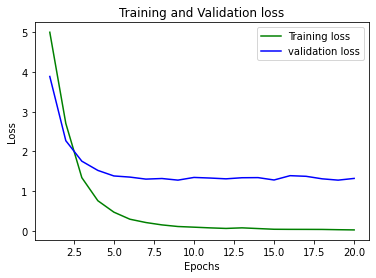

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

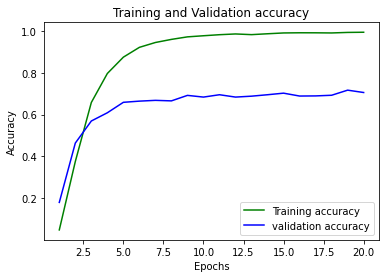

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# evaluate on test set
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3), Precision(), Recall()])
model.evaluate(x=test_datagen)

126/126 [==============================] - 75s 591ms/step - loss: 1.2643 - categorical_accuracy: 0.7135 - top_k_categorical_accuracy: 0.8605 - precision: 0.7979 - recall: 0.6749


[1.2643266916275024,
 0.7134684920310974,
 0.8604651093482971,
 0.7978535890579224,
 0.6749160289764404]

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=2)])
model.evaluate(x=test_datagen)

126/126 [==============================] - 54s 421ms/step - loss: 473.2082 - categorical_accuracy: 0.4824 - top_k_categorical_accuracy: 0.9087


[473.2082214355469, 0.4824026823043823, 0.9087178111076355]

## MobileNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/Shareddrives/ML/MLP/train.zip' .
!cp -r '/content/drive/Shareddrives/ML/MLP/val.zip' .
!cp -r '/content/drive/Shareddrives/ML/MLP/test.zip' .
!unzip train.zip
!unzip val.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/Audi S4 Sedan 2007/01772.jpg  
  inflating: test/Audi S4 Sedan 2007/07660.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05574.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05670.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/06535.jpg  
  inflating: test/Audi S4 Sedan 2007/02743.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05098.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05814.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/04907.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/05078.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/02176.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/02831.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/03905.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/04396.jpg  
  inflating: test/Volkswagen Golf Hatchback 2012/04751.jpg  
  inflating: test/Audi S4 Sedan 2007/03217.jpg  
  inflating: test/Vol

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = 'train'
val_path = 'val'
test_path = 'test'

BATCH_SIZE = 64
train_datagen = ImageDataGenerator(rescale=1./255,
        # shear_range=0.2,
        # rotation_range=20.,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # zoom_range=[0.9, 1.25],
        # brightness_range=[0.5, 1.5],
        horizontal_flip=True).flow_from_directory(train_path, 
                                                  target_size=(224, 224), 
                                                  color_mode="rgb", 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical', 
                                                  shuffle=True, 
                                                  seed=1)
val_datagen = ImageDataGenerator(rescale=1./255,
        # shear_range=0.2,
        # rotation_range=20.,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # zoom_range=[0.9, 1.25],
        # brightness_range=[0.5, 1.5],
        horizontal_flip=True).flow_from_directory(val_path, 
                                                  target_size=(224, 224), 
                                                  color_mode="rgb", 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical', 
                                                  shuffle=True, 
                                                  seed=1)

test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True).flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        color_mode="rgb", 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical',
                                                        shuffle=False, 
                                                        seed=1)

STEP_SIZE_TRAIN = train_datagen.n // train_datagen.batch_size
STEP_SIZE_VALID = val_datagen.n // val_datagen.batch_size


Found 12997 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
# import tensorflow as tf

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print("Device:", tpu.master())
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("Not connected to a TPU runtime. Using CPU/GPU strategy")
#     strategy = tf.distribute.MirroredStrategy()

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

def build_finetune_model(base_model):
    # x = base_model
    # x = GlobalAveragePooling2D(name='avg_pool')(x)
    # x = Dense(1024, activation='relu')
    # x = Dropout(0.5)(x)
    # predictions = Dense(196, activation='softmax', name='finalfc')(x)
    # model = Model(inputs=base_model.input, outputs=predictions)

    model = tf.keras.Sequential([
      base_model,
      GlobalAveragePooling2D(),
      # Dense(512,activation='relu'),
      #keras.layers.Dense(512,activation='relu'),
      Dropout(0.25),
      Dense(196, activation='softmax')
    ])


    return model

In [ ]:
# from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
import tensorflow
import numpy as np

HEIGHT = 224
WIDTH = 224

input_shape=(HEIGHT, WIDTH, 3)

#Initialize MobileNetV2 model - chosen for speed and possibility of millisecond recognition
import tensorflow as tf
IMG_SHAPE = (224,224,3)
base_model = MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Fine tune from this layer onwards, theory is to improve recognition.
fine_tune_at = 75

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model = build_finetune_model(base_model)

adam = Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3)])

earlystopping = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/Shareddrives/ML/mobilenet',
                                                  monitor = 'val_categorical_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  mdome = 'max')
lr_reduce = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=1e-5)

callbacks = [earlystopping, checkpointer, lr_reduce]

STEP_SIZE_TRAIN = train_datagen.n // train_datagen.batch_size
STEP_SIZE_VALID = val_datagen.n // val_datagen.batch_size

epochs = 25

history = model.fit(x=train_datagen,
                              validation_data=val_datagen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=epochs, validation_steps=STEP_SIZE_VALID, callbacks=callbacks)

Epoch 1/25
203/203 [==============================] - ETA: 0s - loss: 3.7197 - categorical_accuracy: 0.2995 - top_k_categorical_accuracy: 0.4397
Epoch 1: val_categorical_accuracy improved from -inf to 0.35500, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 102s 480ms/step - loss: 3.7197 - categorical_accuracy: 0.2995 - top_k_categorical_accuracy: 0.4397 - val_loss: 2.9145 - val_categorical_accuracy: 0.3550 - val_top_k_categorical_accuracy: 0.5469 - lr: 2.0000e-04
Epoch 2/25
203/203 [==============================] - ETA: 0s - loss: 1.4352 - categorical_accuracy: 0.7980 - top_k_categorical_accuracy: 0.9119
Epoch 2: val_categorical_accuracy improved from 0.35500 to 0.56750, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 104s 510ms/step - loss: 1.4352 - categorical_accuracy: 0.7980 - top_k_categorical_accuracy: 0.9119 - val_loss: 1.8324 - val_categorical_accuracy: 0.5675 - val_top_k_categorical_accuracy: 0.7663 - lr: 2.0000e-04
Epoch 3/25
203/203 [==============================] - ETA: 0s - loss: 0.6841 - categorical_accuracy: 0.9328 - top_k_categorical_accuracy: 0.9834
Epoch 3: val_categorical_accuracy improved from 0.56750 to 0.71125, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 97s 480ms/step - loss: 0.6841 - categorical_accuracy: 0.9328 - top_k_categorical_accuracy: 0.9834 - val_loss: 1.2983 - val_categorical_accuracy: 0.7113 - val_top_k_categorical_accuracy: 0.8744 - lr: 2.0000e-04
Epoch 4/25
203/203 [==============================] - ETA: 0s - loss: 0.3548 - categorical_accuracy: 0.9795 - top_k_categorical_accuracy: 0.9973
Epoch 4: val_categorical_accuracy improved from 0.71125 to 0.73750, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 101s 495ms/step - loss: 0.3548 - categorical_accuracy: 0.9795 - top_k_categorical_accuracy: 0.9973 - val_loss: 1.1466 - val_categorical_accuracy: 0.7375 - val_top_k_categorical_accuracy: 0.8988 - lr: 2.0000e-04
Epoch 5/25
203/203 [==============================] - ETA: 0s - loss: 0.1994 - categorical_accuracy: 0.9934 - top_k_categorical_accuracy: 0.9994
Epoch 5: val_categorical_accuracy improved from 0.73750 to 0.75937, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 97s 478ms/step - loss: 0.1994 - categorical_accuracy: 0.9934 - top_k_categorical_accuracy: 0.9994 - val_loss: 1.0431 - val_categorical_accuracy: 0.7594 - val_top_k_categorical_accuracy: 0.9050 - lr: 2.0000e-04
Epoch 6/25
203/203 [==============================] - ETA: 0s - loss: 0.1277 - categorical_accuracy: 0.9970 - top_k_categorical_accuracy: 1.0000
Epoch 6: val_categorical_accuracy improved from 0.75937 to 0.77688, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 95s 466ms/step - loss: 0.1277 - categorical_accuracy: 0.9970 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9544 - val_categorical_accuracy: 0.7769 - val_top_k_categorical_accuracy: 0.9200 - lr: 2.0000e-04
Epoch 7/25
203/203 [==============================] - ETA: 0s - loss: 0.0876 - categorical_accuracy: 0.9979 - top_k_categorical_accuracy: 1.0000
Epoch 7: val_categorical_accuracy improved from 0.77688 to 0.78062, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 101s 496ms/step - loss: 0.0876 - categorical_accuracy: 0.9979 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9182 - val_categorical_accuracy: 0.7806 - val_top_k_categorical_accuracy: 0.9225 - lr: 2.0000e-04
Epoch 8/25
203/203 [==============================] - ETA: 0s - loss: 0.0673 - categorical_accuracy: 0.9978 - top_k_categorical_accuracy: 1.0000
Epoch 8: val_categorical_accuracy did not improve from 0.78062
203/203 [==============================] - 83s 406ms/step - loss: 0.0673 - categorical_accuracy: 0.9978 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9449 - val_categorical_accuracy: 0.7794 - val_top_k_categorical_accuracy: 0.9137 - lr: 2.0000e-04
Epoch 9/25
203/203 [==============================] - ETA: 0s - loss: 0.0503 - categorical_accuracy: 0.9988 - top_k_categorical_accuracy: 1.0000
Epoch 9: val_categorical_accuracy improved from 0.78062 to 0.80187, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 96s 473ms/step - loss: 0.0503 - categorical_accuracy: 0.9988 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8349 - val_categorical_accuracy: 0.8019 - val_top_k_categorical_accuracy: 0.9281 - lr: 2.0000e-04
Epoch 10/25
203/203 [==============================] - ETA: 0s - loss: 0.0429 - categorical_accuracy: 0.9984 - top_k_categorical_accuracy: 0.9999
Epoch 10: val_categorical_accuracy improved from 0.80187 to 0.80813, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 96s 471ms/step - loss: 0.0429 - categorical_accuracy: 0.9984 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.8069 - val_categorical_accuracy: 0.8081 - val_top_k_categorical_accuracy: 0.9294 - lr: 2.0000e-04
Epoch 11/25
203/203 [==============================] - ETA: 0s - loss: 0.0334 - categorical_accuracy: 0.9985 - top_k_categorical_accuracy: 1.0000
Epoch 11: val_categorical_accuracy improved from 0.80813 to 0.81500, saving model to /content/drive/Shareddrives/ML/mobilenet


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 95s 469ms/step - loss: 0.0334 - categorical_accuracy: 0.9985 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7862 - val_categorical_accuracy: 0.8150 - val_top_k_categorical_accuracy: 0.9281 - lr: 2.0000e-04
Epoch 12/25
203/203 [==============================] - ETA: 0s - loss: 0.0321 - categorical_accuracy: 0.9976 - top_k_categorical_accuracy: 1.0000
Epoch 12: val_categorical_accuracy did not improve from 0.81500
203/203 [==============================] - 81s 399ms/step - loss: 0.0321 - categorical_accuracy: 0.9976 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8173 - val_categorical_accuracy: 0.8044 - val_top_k_categorical_accuracy: 0.9150 - lr: 2.0000e-04
Epoch 13/25
203/203 [==============================] - ETA: 0s - loss: 0.0246 - categorical_accuracy: 0.9991 - top_k_categorical_accuracy: 1.0000
Epoch 13: val_categorical_accuracy did not improve from 0.81500
203/203 [==============================] - 81s 400ms/step - loss: 0.0246 -

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet/assets


203/203 [==============================] - 97s 476ms/step - loss: 0.0180 - categorical_accuracy: 0.9987 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7553 - val_categorical_accuracy: 0.8275 - val_top_k_categorical_accuracy: 0.9312 - lr: 2.0000e-04
Epoch 17/25
203/203 [==============================] - ETA: 0s - loss: 0.0169 - categorical_accuracy: 0.9988 - top_k_categorical_accuracy: 0.9999
Epoch 17: val_categorical_accuracy did not improve from 0.82750
203/203 [==============================] - 84s 415ms/step - loss: 0.0169 - categorical_accuracy: 0.9988 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.7314 - val_categorical_accuracy: 0.8200 - val_top_k_categorical_accuracy: 0.9337 - lr: 2.0000e-04
Epoch 18/25
203/203 [==============================] - ETA: 0s - loss: 0.0172 - categorical_accuracy: 0.9988 - top_k_categorical_accuracy: 1.0000
Epoch 18: val_categorical_accuracy did not improve from 0.82750
203/203 [==============================] - 84s 416ms/step - loss: 0.0172 -

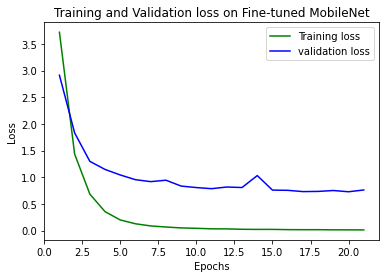

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,22)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss on Fine-tuned MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

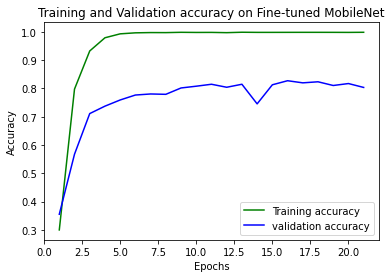

In [ ]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,22)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy on Fine-tuned MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/Shareddrives/ML/mobilenet')

In [ ]:
# evaluate on test set
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.0002)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3), Precision(), Recall()])
model.evaluate(test_datagen)

126/126 [==============================] - 49s 368ms/step - loss: 0.7582 - categorical_accuracy: 0.8133 - top_k_categorical_accuracy: 0.9336 - precision: 0.9137 - recall: 0.7059


[0.7581677436828613,
 0.813331663608551,
 0.9335903525352478,
 0.9137153625488281,
 0.7058823704719543]

In [ ]:
train_datagen.class_indices

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [ ]:
test_datagen.class_indices

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

### Fine-tune MobileNet

In [ ]:
!pip install keras-tuner

In [ ]:
for i in range(1, 2):
  print('hello')

hello


In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

IMG_SHAPE = (224,224,3)
base_model = MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

def build_model(hp):
  model = Sequential()
  base_model.trainable = False
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  for i in range(1, hp.Int("num_layers", 1, 2)):
    model.add(Dense(units=hp.Int("units_" + str(i), min_value=256, max_value=512, step=256), activation='relu'))
  model.add(Dropout(hp.Float(name='dropout', min_value=0.25, max_value=0.5, step=0.25)))
  model.add(Dense(196, activation='softmax'))

  model.compile(optimizer=optimizers.Adam(learning_rate=1e-2), loss=losses.CategoricalCrossentropy(), metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3), Recall(), Precision()])

  return model

  # model = tf.keras.Sequential([
  #   base_model,
  #   GlobalAveragePooling2D(),
  #   # Dense(512,activation='relu'),
  #   #keras.layers.Dense(512,activation='relu'),
  #   Dropout(0.25),
  #   Dense(196, activation='softmax')
  # ])


In [ ]:
import keras_tuner as kt
from tensorflow.keras import optimizers, losses, callbacks
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall

tuner = kt.Hyperband(build_model,
                     objective="val_categorical_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=5,
                     directory='/content/drive/Shareddrives/ML/MobileNet_hyperparam_3',
                     project_name="kt_hyperband",)

NUM_EPOCHS = 10
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x=train_datagen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_datagen, validation_steps=STEP_SIZE_VALID, epochs=NUM_EPOCHS, callbacks=[stop_early, callbacks.TensorBoard('/content/drive/Shareddrives/ML/MobileNet_hyperparam_log')])

Trial 10 Complete [00h 05m 10s]
val_categorical_accuracy: 0.49687498807907104

Best val_categorical_accuracy So Far: 0.5462499856948853
Total elapsed time: 00h 56m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]

for i, setting in enumerate(tuner.get_best_hyperparameters(num_trials=10)):
  print(f'SETTING RANK {i}')
  print('num layers ', setting.get('num_layers') - 1)
  print('dropout', setting.get('dropout'))
  try:
    print('nodes', setting.get('units_1'))
  except:
    print()
  print('\n')

SETTING RANK 0
num layers  0
dropout 0.25



SETTING RANK 1
num layers  0
dropout 0.25
nodes 256


SETTING RANK 2
num layers  0
dropout 0.25
nodes 512


SETTING RANK 3
num layers  0
dropout 0.5
nodes 512


SETTING RANK 4
num layers  0
dropout 0.5
nodes 256


SETTING RANK 5
num layers  1
dropout 0.25
nodes 512


SETTING RANK 6
num layers  1
dropout 0.25
nodes 256


SETTING RANK 7
num layers  1
dropout 0.25
nodes 256


SETTING RANK 8
num layers  1
dropout 0.5
nodes 512


SETTING RANK 9
num layers  1
dropout 0.5
nodes 256




In [ ]:
tuner.get_best_models()

In [ ]:
tuner.get_state()

{}

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall
from tensorflow.keras.applications import MobileNet

IMG_SHAPE = (224,224,3)
base_model = MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

def build_model():
  model = Sequential()
  base_model.trainable = False
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.25))
  model.add(Dense(196, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=1e-2), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3), Recall(), Precision()])

  return model

In [ ]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
model = build_model()
lrfinder = LRFinder(model)
lrfinder.find_generator(train_datagen, start_lr=1e-8, end_lr=1e-2, epochs=5, steps_per_epoch=STEP_SIZE_TRAIN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
203/203 [==============================] - 87s 358ms/step - loss: 6.4242 - categorical_accuracy: 0.0040 - top_k_categorical_accuracy: 0.0147 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 2/5
203/203 [==============================] - 73s 357ms/step - loss: 6.4234 - categorical_accuracy: 0.0043 - top_k_categorical_accuracy: 0.0145 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 3/5
203/203 [==============================] - 72s 355ms/step - loss: 6.2260 - categorical_accuracy: 0.0045 - top_k_categorical_accuracy: 0.0131 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 4/5
203/203 [==============================] - 74s 362ms/step - loss: 5.5310 - categorical_accuracy: 0.0163 - top_k_categorical_accuracy: 0.0379 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 5/5
203/203 [==============================] - 72s 355ms/step - loss: 3.7300 - categorical_accuracy: 0.2136 - top_k_categorical_accuracy: 0.3588 - recall_1: 0.0694 - precision_1: 0.6319


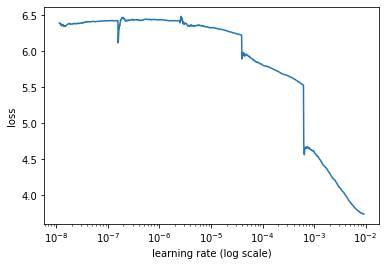

In [ ]:
lrfinder.plot_loss()

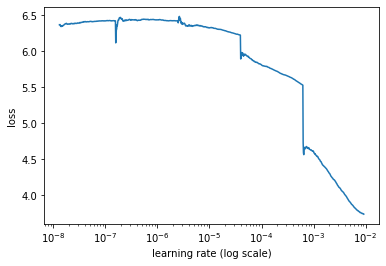

In [ ]:
lrfinder.plot_loss(n_skip_beginning=20, n_skip_end=5)

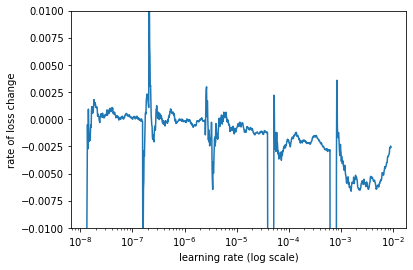

In [ ]:
lrfinder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

In [ ]:
lrfinder.get_best_lr(sma=100, n_skip_beginning=20, n_skip_end=5)

0.002427848

## Transfer Learning on Base First

In [ ]:
from tensorflow.keras import callbacks
IMG_SHAPE = (224,224,3)
base_model = MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

def build_model():
  model = Sequential()
  base_model.trainable = False
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.25))
  model.add(Dense(196, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=1e-2), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3), Recall(), Precision()])

  return model

model = build_model()
earlystopping = callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = callbacks.ModelCheckpoint(filepath = '/content/drive/Shareddrives/ML/mobilenet_base_frozen',
                                                  monitor = 'val_categorical_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  mdome = 'max')
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=1e-5)

callbacks = [earlystopping, checkpointer, lr_reduce]

STEP_SIZE_TRAIN = train_datagen.n // train_datagen.batch_size
STEP_SIZE_VALID = val_datagen.n // val_datagen.batch_size

epochs = 20

history = model.fit(x=train_datagen,
                              validation_data=val_datagen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=epochs, validation_steps=STEP_SIZE_VALID, callbacks=callbacks)

Epoch 1/20
203/203 [==============================] - ETA: 0s - loss: 4.7630 - categorical_accuracy: 0.2864 - top_k_categorical_accuracy: 0.4343 - recall_4: 0.2250 - precision_4: 0.4806
Epoch 1: val_categorical_accuracy improved from -inf to 0.40625, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 103s 496ms/step - loss: 4.7630 - categorical_accuracy: 0.2864 - top_k_categorical_accuracy: 0.4343 - recall_4: 0.2250 - precision_4: 0.4806 - val_loss: 3.3441 - val_categorical_accuracy: 0.4062 - val_top_k_categorical_accuracy: 0.6006 - val_recall_4: 0.3487 - val_precision_4: 0.5355 - lr: 0.0100
Epoch 2/20
203/203 [==============================] - ETA: 0s - loss: 2.0050 - categorical_accuracy: 0.5953 - top_k_categorical_accuracy: 0.7782 - recall_4: 0.5538 - precision_4: 0.6795
Epoch 2: val_categorical_accuracy improved from 0.40625 to 0.49312, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 98s 484ms/step - loss: 2.0050 - categorical_accuracy: 0.5953 - top_k_categorical_accuracy: 0.7782 - recall_4: 0.5538 - precision_4: 0.6795 - val_loss: 3.1992 - val_categorical_accuracy: 0.4931 - val_top_k_categorical_accuracy: 0.6631 - val_recall_4: 0.4538 - val_precision_4: 0.5803 - lr: 0.0100
Epoch 3/20
203/203 [==============================] - ETA: 0s - loss: 1.5119 - categorical_accuracy: 0.6872 - top_k_categorical_accuracy: 0.8500 - recall_4: 0.6616 - precision_4: 0.7377
Epoch 3: val_categorical_accuracy improved from 0.49312 to 0.53000, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 99s 488ms/step - loss: 1.5119 - categorical_accuracy: 0.6872 - top_k_categorical_accuracy: 0.8500 - recall_4: 0.6616 - precision_4: 0.7377 - val_loss: 2.9598 - val_categorical_accuracy: 0.5300 - val_top_k_categorical_accuracy: 0.7075 - val_recall_4: 0.5075 - val_precision_4: 0.5876 - lr: 0.0100
Epoch 4/20
203/203 [==============================] - ETA: 0s - loss: 1.3581 - categorical_accuracy: 0.7365 - top_k_categorical_accuracy: 0.8871 - recall_4: 0.7189 - precision_4: 0.7712
Epoch 4: val_categorical_accuracy improved from 0.53000 to 0.56875, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 99s 490ms/step - loss: 1.3581 - categorical_accuracy: 0.7365 - top_k_categorical_accuracy: 0.8871 - recall_4: 0.7189 - precision_4: 0.7712 - val_loss: 2.8951 - val_categorical_accuracy: 0.5688 - val_top_k_categorical_accuracy: 0.7387 - val_recall_4: 0.5444 - val_precision_4: 0.6104 - lr: 0.0100
Epoch 5/20
203/203 [==============================] - ETA: 0s - loss: 1.1673 - categorical_accuracy: 0.7718 - top_k_categorical_accuracy: 0.9091 - recall_4: 0.7580 - precision_4: 0.7969
Epoch 5: val_categorical_accuracy did not improve from 0.56875
203/203 [==============================] - 85s 418ms/step - loss: 1.1673 - categorical_accuracy: 0.7718 - top_k_categorical_accuracy: 0.9091 - recall_4: 0.7580 - precision_4: 0.7969 - val_loss: 3.1641 - val_categorical_accuracy: 0.5638 - val_top_k_categorical_accuracy: 0.7469 - val_recall_4: 0.5462 - val_precision_4: 0.6007 - lr: 0.0100
Epoch 6/20
203/203 [==============================] - ETA: 0s - loss: 1.0

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 98s 485ms/step - loss: 1.0730 - categorical_accuracy: 0.7925 - top_k_categorical_accuracy: 0.9207 - recall_4: 0.7829 - precision_4: 0.8150 - val_loss: 3.2724 - val_categorical_accuracy: 0.5738 - val_top_k_categorical_accuracy: 0.7575 - val_recall_4: 0.5587 - val_precision_4: 0.6061 - lr: 0.0100
Epoch 7/20
203/203 [==============================] - ETA: 0s - loss: 1.0307 - categorical_accuracy: 0.8024 - top_k_categorical_accuracy: 0.9297 - recall_4: 0.7936 - precision_4: 0.8189
Epoch 7: val_categorical_accuracy did not improve from 0.57375
203/203 [==============================] - 84s 412ms/step - loss: 1.0307 - categorical_accuracy: 0.8024 - top_k_categorical_accuracy: 0.9297 - recall_4: 0.7936 - precision_4: 0.8189 - val_loss: 3.5894 - val_categorical_accuracy: 0.5587 - val_top_k_categorical_accuracy: 0.7431 - val_recall_4: 0.5506 - val_precision_4: 0.5850 - lr: 0.0100
Epoch 8/20
203/203 [==============================] - ETA: 0s - loss: 1.0

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 98s 484ms/step - loss: 1.0072 - categorical_accuracy: 0.8263 - top_k_categorical_accuracy: 0.9429 - recall_4: 0.8207 - precision_4: 0.8366 - val_loss: 3.7597 - val_categorical_accuracy: 0.5938 - val_top_k_categorical_accuracy: 0.7575 - val_recall_4: 0.5850 - val_precision_4: 0.6118 - lr: 0.0100
Epoch 10/20
203/203 [==============================] - ETA: 0s - loss: 0.9273 - categorical_accuracy: 0.8365 - top_k_categorical_accuracy: 0.9502 - recall_4: 0.8326 - precision_4: 0.8467
Epoch 10: val_categorical_accuracy did not improve from 0.59375
203/203 [==============================] - 83s 410ms/step - loss: 0.9273 - categorical_accuracy: 0.8365 - top_k_categorical_accuracy: 0.9502 - recall_4: 0.8326 - precision_4: 0.8467 - val_loss: 4.1279 - val_categorical_accuracy: 0.5625 - val_top_k_categorical_accuracy: 0.7475 - val_recall_4: 0.5550 - val_precision_4: 0.5842 - lr: 0.0100
Epoch 11/20
203/203 [==============================] - ETA: 0s - loss: 

In [ ]:
# Fine tune from this layer onwards, theory is to improve recognition.
fine_tune_at = 75

model.layers[0].trainable = True
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[0].layers[:fine_tune_at]:
  layer.trainable =  False

adam = Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3), Precision(), Recall()])

In [ ]:
history_2 = model.fit(x=train_datagen,
                              validation_data=val_datagen,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=epochs, validation_steps=STEP_SIZE_VALID, callbacks=callbacks)

Epoch 1/20
203/203 [==============================] - ETA: 0s - loss: 1.4958 - categorical_accuracy: 0.7903 - top_k_categorical_accuracy: 0.9142 - precision_5: 0.8024 - recall_5: 0.7851
Epoch 1: val_categorical_accuracy did not improve from 0.59375
203/203 [==============================] - 92s 430ms/step - loss: 1.4958 - categorical_accuracy: 0.7903 - top_k_categorical_accuracy: 0.9142 - precision_5: 0.8024 - recall_5: 0.7851 - val_loss: 4.2922 - val_categorical_accuracy: 0.5900 - val_top_k_categorical_accuracy: 0.7481 - val_precision_5: 0.6115 - val_recall_5: 0.5825 - lr: 2.0000e-04
Epoch 2/20
203/203 [==============================] - ETA: 0s - loss: 0.3792 - categorical_accuracy: 0.9198 - top_k_categorical_accuracy: 0.9843 - precision_5: 0.9246 - recall_5: 0.9171
Epoch 2: val_categorical_accuracy improved from 0.59375 to 0.60562, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 102s 500ms/step - loss: 0.3792 - categorical_accuracy: 0.9198 - top_k_categorical_accuracy: 0.9843 - precision_5: 0.9246 - recall_5: 0.9171 - val_loss: 3.7444 - val_categorical_accuracy: 0.6056 - val_top_k_categorical_accuracy: 0.7819 - val_precision_5: 0.6222 - val_recall_5: 0.5981 - lr: 2.0000e-04
Epoch 3/20
203/203 [==============================] - ETA: 0s - loss: 0.2640 - categorical_accuracy: 0.9398 - top_k_categorical_accuracy: 0.9911 - precision_5: 0.9439 - recall_5: 0.9373
Epoch 3: val_categorical_accuracy did not improve from 0.60562
203/203 [==============================] - 85s 416ms/step - loss: 0.2640 - categorical_accuracy: 0.9398 - top_k_categorical_accuracy: 0.9911 - precision_5: 0.9439 - recall_5: 0.9373 - val_loss: 3.8776 - val_categorical_accuracy: 0.5881 - val_top_k_categorical_accuracy: 0.7944 - val_precision_5: 0.6039 - val_recall_5: 0.5813 - lr: 2.0000e-04
Epoch 4/20
203/203 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 99s 486ms/step - loss: 0.1818 - categorical_accuracy: 0.9576 - top_k_categorical_accuracy: 0.9944 - precision_5: 0.9592 - recall_5: 0.9563 - val_loss: 2.8465 - val_categorical_accuracy: 0.6731 - val_top_k_categorical_accuracy: 0.8431 - val_precision_5: 0.6885 - val_recall_5: 0.6687 - lr: 2.0000e-04
Epoch 6/20
203/203 [==============================] - ETA: 0s - loss: 0.1402 - categorical_accuracy: 0.9647 - top_k_categorical_accuracy: 0.9964 - precision_5: 0.9668 - recall_5: 0.9640
Epoch 6: val_categorical_accuracy improved from 0.67313 to 0.68250, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 99s 490ms/step - loss: 0.1402 - categorical_accuracy: 0.9647 - top_k_categorical_accuracy: 0.9964 - precision_5: 0.9668 - recall_5: 0.9640 - val_loss: 2.7752 - val_categorical_accuracy: 0.6825 - val_top_k_categorical_accuracy: 0.8506 - val_precision_5: 0.6977 - val_recall_5: 0.6781 - lr: 2.0000e-04
Epoch 7/20
203/203 [==============================] - ETA: 0s - loss: 0.1390 - categorical_accuracy: 0.9650 - top_k_categorical_accuracy: 0.9968 - precision_5: 0.9667 - recall_5: 0.9643
Epoch 7: val_categorical_accuracy did not improve from 0.68250
203/203 [==============================] - 85s 419ms/step - loss: 0.1390 - categorical_accuracy: 0.9650 - top_k_categorical_accuracy: 0.9968 - precision_5: 0.9667 - recall_5: 0.9643 - val_loss: 3.2335 - val_categorical_accuracy: 0.6656 - val_top_k_categorical_accuracy: 0.8244 - val_precision_5: 0.6808 - val_recall_5: 0.6625 - lr: 2.0000e-04
Epoch 8/20
203/203 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 100s 493ms/step - loss: 0.1118 - categorical_accuracy: 0.9727 - top_k_categorical_accuracy: 0.9978 - precision_5: 0.9744 - recall_5: 0.9721 - val_loss: 2.7454 - val_categorical_accuracy: 0.7006 - val_top_k_categorical_accuracy: 0.8575 - val_precision_5: 0.7124 - val_recall_5: 0.6950 - lr: 2.0000e-04
Epoch 10/20
203/203 [==============================] - ETA: 0s - loss: 0.0966 - categorical_accuracy: 0.9764 - top_k_categorical_accuracy: 0.9979 - precision_5: 0.9776 - recall_5: 0.9756
Epoch 10: val_categorical_accuracy improved from 0.70063 to 0.71562, saving model to /content/drive/Shareddrives/ML/mobilenet_base_frozen


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ML/mobilenet_base_frozen/assets


203/203 [==============================] - 100s 491ms/step - loss: 0.0966 - categorical_accuracy: 0.9764 - top_k_categorical_accuracy: 0.9979 - precision_5: 0.9776 - recall_5: 0.9756 - val_loss: 2.6776 - val_categorical_accuracy: 0.7156 - val_top_k_categorical_accuracy: 0.8594 - val_precision_5: 0.7310 - val_recall_5: 0.7100 - lr: 2.0000e-04
Epoch 11/20
203/203 [==============================] - ETA: 0s - loss: 0.0772 - categorical_accuracy: 0.9820 - top_k_categorical_accuracy: 0.9989 - precision_5: 0.9827 - recall_5: 0.9814
Epoch 11: val_categorical_accuracy did not improve from 0.71562
203/203 [==============================] - 87s 430ms/step - loss: 0.0772 - categorical_accuracy: 0.9820 - top_k_categorical_accuracy: 0.9989 - precision_5: 0.9827 - recall_5: 0.9814 - val_loss: 2.5183 - val_categorical_accuracy: 0.7119 - val_top_k_categorical_accuracy: 0.8769 - val_precision_5: 0.7245 - val_recall_5: 0.7050 - lr: 2.0000e-04
Epoch 12/20
203/203 [==============================] - ETA: 0s

KeyboardInterrupt: ignored

## Error Analysis

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/Shareddrives/ML/mobilenet')

In [ ]:
import numpy as np

predictions = model.predict(test_datagen)
pred = np.argmax(predictions, axis=1)
errors = pred == test_datagen.classes

In [ ]:
test_datagen.classes

array([  0,   0,   0, ..., 195, 195, 195], dtype=int32)

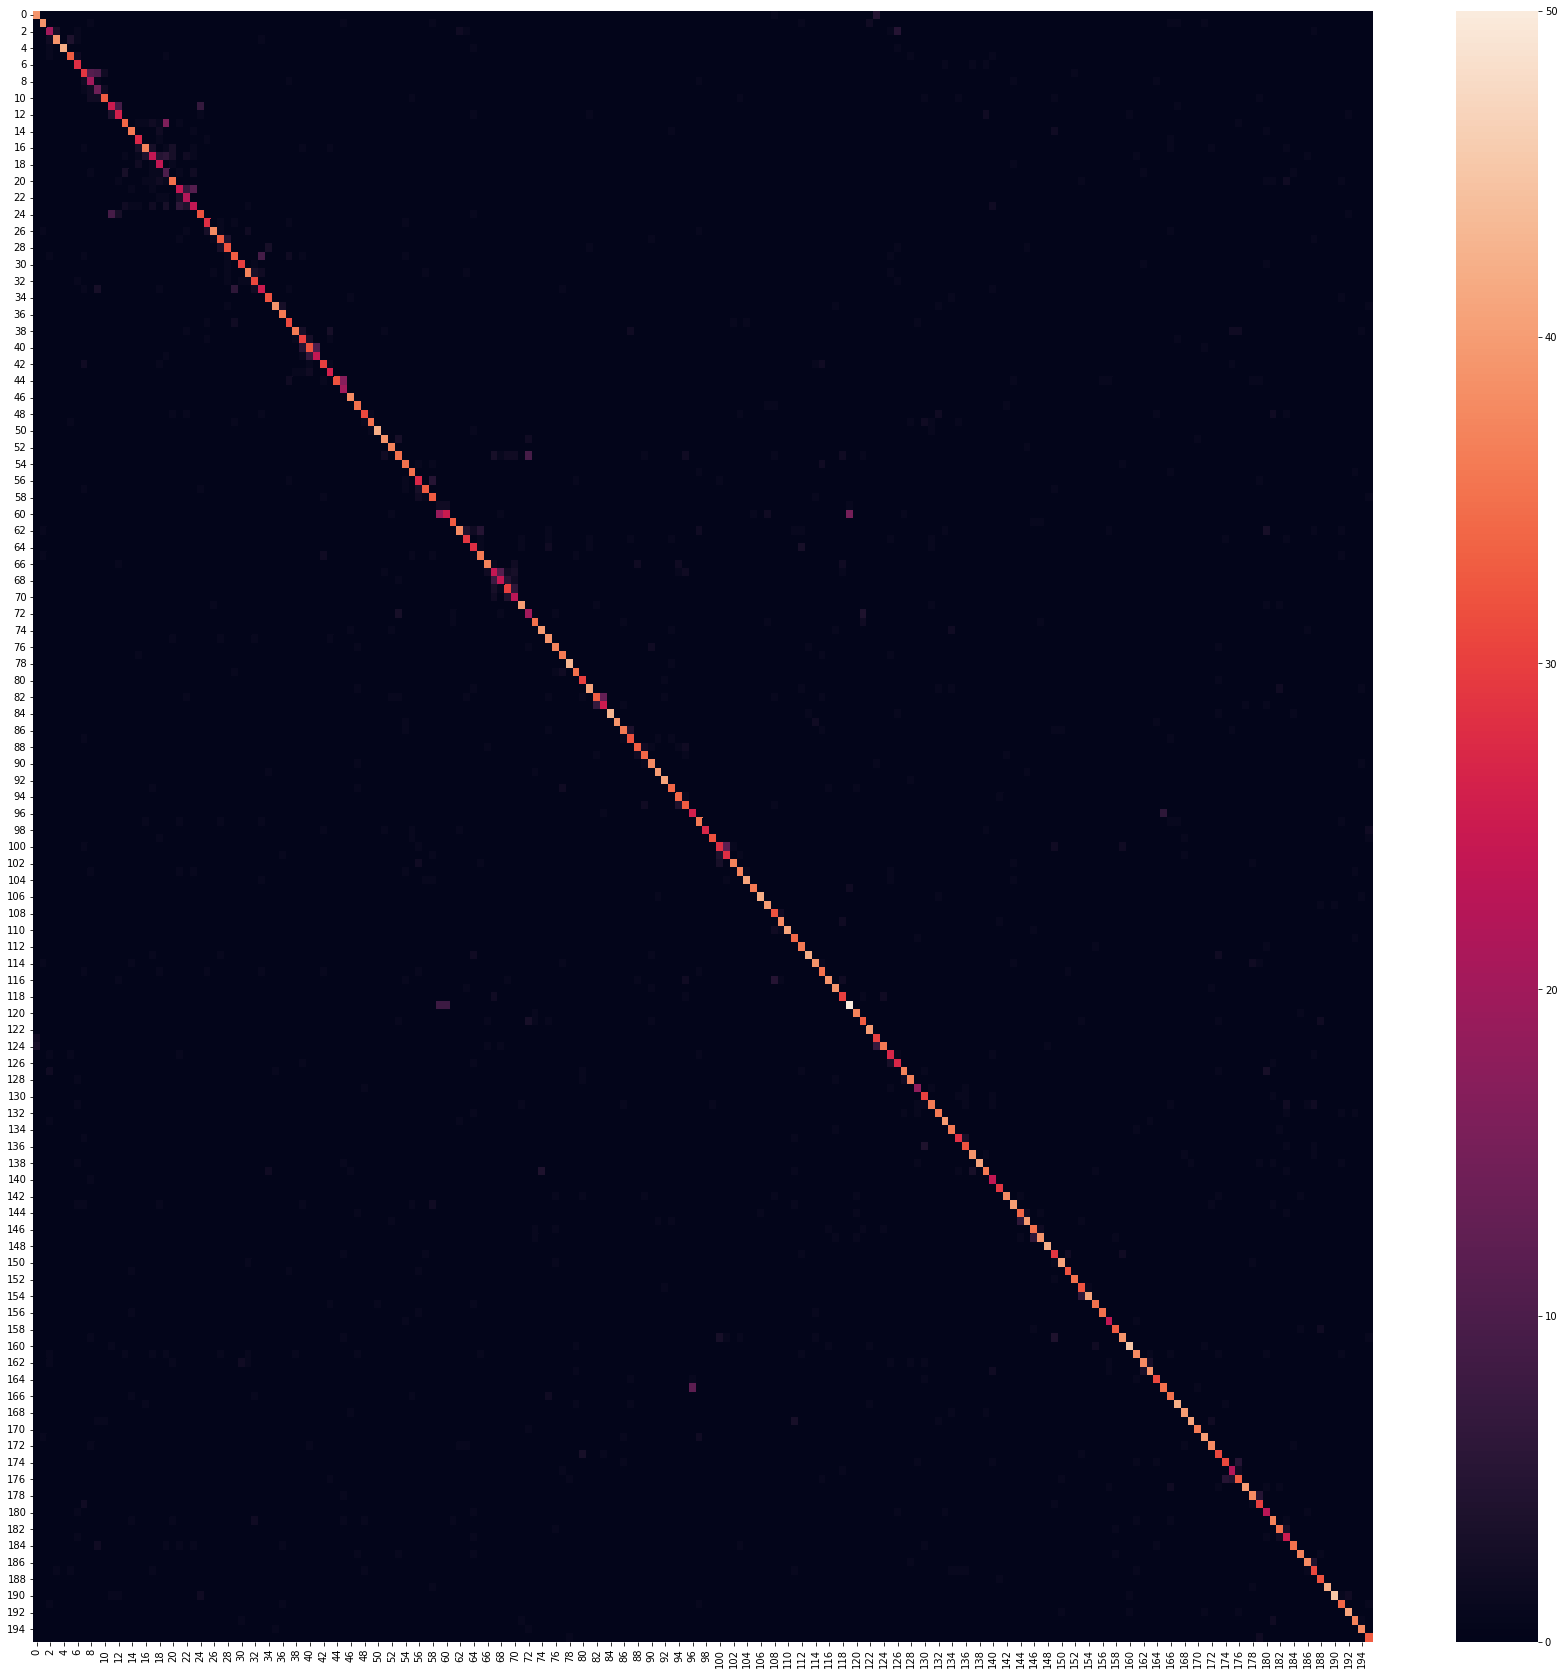

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plt.figure(figsize=(30, 30))
sns.heatmap(confusion_matrix(pred, test_datagen.classes))

In [ ]:
pred

array([  0,   0,   0, ..., 195,  99, 195])

In [ ]:
test_datagen.classes

array([  0,   0,   0, ..., 195, 195, 195], dtype=int32)

In [ ]:
len(test_datagen.filenames)

8041

In [ ]:
# from PIL import Image
# from os.path import join
# import IPython.display as display
# import cv2
# from textwrap import wrap

# # create figure
# fig = plt.figure(figsize=(30, 50))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.5, 
#                     right=0.9, 
#                     top=1.2, 
#                     wspace=0.4, 
#                     hspace=0.4)
# # fig.tight_layout()
# # setting values to rows and column variables
# rows = 10
# columns = 4

# label_mapping = {y: x for x, y in test_datagen.class_indices.items()}
# counter = 0
# for i in range(len(errors)):
#   if errors[i] == False:
#     im = cv2.imread(join('test', test_datagen.filenames[i]))
#     im = cv2.resize(im, (400, 224))
    
#     fig.add_subplot(rows, columns, counter + 1).set_title("\n".join(wrap(f'Original: {label_mapping[test_datagen.classes[i]]} | \n' + f'Prediction: {label_mapping[pred[i]]}', width=40)), fontdict={'fontsize':16})
#     plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
#     # plt.title(f'Original: {label_mapping[test_datagen.classes[i]]} | \n' + f'Prediction: {label_mapping[pred[i]]}', fontdict={'fontsize':14}, wrap=True)
#     plt.axis('off')
#     # print(f'Original: {label_mapping[test_datagen.classes[i]]}')
#     # print(f'Prediction: {label_mapping[pred[i]]}')
#     counter += 1
#     if counter == 40:
#       break
from PIL import Image
from os.path import join
import IPython.display as display
import cv2
from textwrap import wrap

# create figure
fig = plt.figure(figsize=(30, 50))
plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
# fig.tight_layout()
# setting values to rows and column variables
rows = 10
columns = 4

label_mapping = {y: x for x, y in test_datagen.class_indices.items()}
counter = 0
even_counter = 100
for i in range(len(errors)):
  if errors[i] == False and even_counter % 100 == 0:
    im = cv2.imread(join('test', test_datagen.filenames[i]))
    im = cv2.resize(im, (400, 224))
    
    fig.add_subplot(rows, columns, counter + 1).set_title("\n".join(wrap(f'Original: {label_mapping[test_datagen.classes[i]]} | \n' + f'Prediction: {label_mapping[pred[i]]}', width=40)), fontdict={'fontsize':16})
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    # plt.title(f'Original: {label_mapping[test_datagen.classes[i]]} | \n' + f'Prediction: {label_mapping[pred[i]]}', fontdict={'fontsize':14}, wrap=True)
    plt.axis('off')
    # print(f'Original: {label_mapping[test_datagen.classes[i]]}')
    # print(f'Prediction: {label_mapping[pred[i]]}')
    counter += 1
    if counter == 1000:
      break
  even_counter += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_datagen[100][0]

array([[[[0.43529415, 0.43137258, 0.42352945],
         [0.43921572, 0.43529415, 0.427451  ],
         [0.4431373 , 0.43921572, 0.43137258],
         ...,
         [0.4431373 , 0.4431373 , 0.4431373 ],
         [0.4431373 , 0.4431373 , 0.4431373 ],
         [0.44705886, 0.43921572, 0.4431373 ]],

        [[0.43529415, 0.43137258, 0.42352945],
         [0.43921572, 0.43529415, 0.427451  ],
         [0.4431373 , 0.43921572, 0.43137258],
         ...,
         [0.4431373 , 0.4431373 , 0.4431373 ],
         [0.4431373 , 0.4431373 , 0.4431373 ],
         [0.44705886, 0.43921572, 0.4431373 ]],

        [[0.39607847, 0.3921569 , 0.38431376],
         [0.39607847, 0.3921569 , 0.38431376],
         [0.39607847, 0.3921569 , 0.38431376],
         ...,
         [0.4784314 , 0.4784314 , 0.4784314 ],
         [0.47450984, 0.47450984, 0.47450984],
         [0.49411768, 0.48627454, 0.4901961 ]],

        ...,

        [[0.37254903, 0.3647059 , 0.36862746],
         [0.3803922 , 0.37254903, 0.37647063]